In [1]:
# All the required imports

import pandas as pd
import numpy as np
import os
import torch
import torchvision
from torchvision import transforms,models
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
from torch import nn
import torch.nn.functional as F
from torch import optim
from skimage import io, transform

from PIL import Image

%matplotlib inline 

In [2]:
# Exploring train.csv file
df = pd.read_csv('../input/train.csv')
df.head()

,Category,Id
0,41,zwnluz.jpg
1,6,ptsbsg.jpg
2,15,txhnvq.jpg
3,18,bulncb.jpg
4,18,tkvqyc.jpg


In [3]:
#Dataset class

class ImageDataset(Dataset):
    

    def __init__(self, csv_file, root_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with labels.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.data_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.data_frame)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.data_frame['Id'][idx])         # getting path of image
        image = Image.open(img_name).convert('RGB')                                # reading image and converting to rgb if it is grayscale
        label = np.array(self.data_frame['Category'][idx])                         # reading label of the image
        
        if self.transform:            
            image = self.transform(image)                                          # applying transforms, if any
        
        sample = (image, label)        
        return sample

In [4]:
# Transforms to be applied to each image (you can add more transforms), resizing every image to 3 x 224 x 224 size and converting to Tensor
from torch.utils.data.sampler import SubsetRandomSampler

transform = transforms.Compose([
                                 transforms.RandomHorizontalFlip(),transforms.RandomResizedCrop(299),
                                transforms.ToTensor() ,
                               
                                
                                ])


dataset = ImageDataset(csv_file = '../input/train.csv', root_dir = '../input/data/data/', transform=transform)     #Training Dataset
train_loader = torch.utils.data.DataLoader(dataset, batch_size=16 , shuffle = True)
#Train loader, can change the batch_size to your own choice

In [5]:
#Checking training sample size and label
for i in range(len(dataset)):
    sample = dataset[i]
    print(i, sample[0].size(), " | Label: ", sample[1])
    if i == 9:
        break

0 torch.Size([3, 299, 299])  | Label:  41
1 torch.Size([3, 299, 299])  | Label:  6
2 torch.Size([3, 299, 299])  | Label:  15
3 torch.Size([3, 299, 299])  | Label:  18
4 torch.Size([3, 299, 299])  | Label:  18
5 torch.Size([3, 299, 299])  | Label:  3
6 torch.Size([3, 299, 299])  | Label:  34
7 torch.Size([3, 299, 299])  | Label:  57
8 torch.Size([3, 299, 299])  | Label:  4
9 torch.Size([3, 299, 299])  | Label:  33


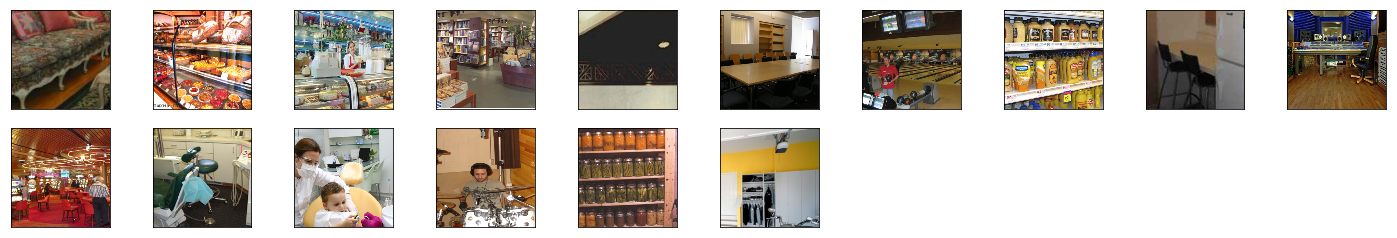

In [6]:
# Visualizing some sample data
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(16):                                             #Change the range according to your batch-size
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx], (1, 2, 0)))

In [7]:
# check if CUDA / GPU is available, if unavaiable then turn it on from the right side panel under SETTINGS, also turn on the Internet
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [8]:

model = models.inception_v3(pretrained=True)
# Define your CNN model here, shift it to GPU if needed
ct = 0
for child in model.children():
    ct += 1
    if ct < 17:
        for param in child.parameters():
            param.requires_grad = False
ac = nn.Sequential(
nn.Dropout(0.2),
    nn.ReLU(),
nn.Linear(768,67))

mc = nn.Sequential(
nn.Dropout(0.2),
    nn.ReLU(),
nn.Linear(2048,67))
            
model.AuxLogits.fc = ac
model.fc = mc

criterion = nn.CrossEntropyLoss()
model.cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
# Define your CNN model here, shift it to GPU if needed


Downloading: "https://download.pytorch.org/models/inception_v3_google-1a9a5a14.pth" to /tmp/.cache/torch/checkpoints/inception_v3_google-1a9a5a14.pth
100%|██████████| 108857766/108857766 [00:00<00:00, 119823098.91it/s]


In [9]:
from torch.autograd import Variable
device = 'cuda'
# Training Loop (You can write your own loop from scratch)
n_epochs = 10    #number of epochs, change this accordingly
for epoch in range(1, n_epochs+1):
    for n_batch, (images,labels) in enumerate(train_loader):
        images ,labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        output,_ = model(images)
        auxout,_ = model(images)
        loss1 = criterion(output,labels)
        loss2 = criterion(auxout,labels)
        loss = loss1+(0.34*loss2)
        loss.backward()
        optimizer.step()


In [10]:
#Exit training mode and set model to evaluation mode
model.eval() # eval mode


Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, t

In [11]:
# Reading sample_submission file to get the test image names
submission = pd.read_csv('../input/sample_sub.csv')
submission.head()

,Category,Id
0,0,fysglz.jpg
1,0,dyiwdi.jpg
2,0,blyymx.jpg
3,0,xkyygh.jpg
4,0,efobnp.jpg


In [12]:
#Loading test data to make predictions
testset = ImageDataset(csv_file = '../input/sample_sub.csv', root_dir = '../input/data/data/', transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=16, shuffle=False, num_workers=0)

In [13]:
predictions = []
# iterate over test data to make predictions
for data, target in testloader:
    # move tensors to GPU if CUDA is available
    
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    _, pred = torch.max(output, 1)
    for i in range(len(pred)):
        predictions.append(int(pred[i]))
        

submission['Category'] = predictions             #Attaching predictions to submission file

   

In [14]:

#saving submission file
submission.to_csv('submission.csv', index=False, encoding='utf-8')
